## Lab: Radiative Convective Equilibrium (RCE) for Climate Sensitivity and Feedbacks

EESC 9926, Idealized Models of Climate Processes, Columbia University

Using the `konrad` implementation of a single-column radiative-convective equilibrium model.

Version history:
- Spring 2023 Robert Pincus for EESC 6926  (Lab 1 and 2) 
- Fall 2025 modifed by Galen McKinley for EESC 6926 (Lab 4) 

## 0. Introduction: Radiative-convective equilibrium as an idealized problem for climate

Imagine a pot of water on a stove, heated from below. As the water in the bottom of the pot warms it becomes less dense than the water above it and rises, causing the water to overturn (circulate in the vertical). Cooling from the top can also cause an overturning circulation - this is what you see in a bowl of miso soup. Any temperature profile in which deeper water is warmer than shallow water is "unstable" in this way, and will mix in the vertical. The vertical water motions are called "convection". 

The earth's atmosphere differs from a bowl of miso soup in three important ways (for the purposes of this discussion). 

First, the atmosphere is compressible, meaning that the pressure decreases roughly exponentially with distance from the surface. Conservation of energy means that the temperature of the air also has to decrease with height. This means that the condition of stability isn't "is the air below a given location warmer/less dense than the air at the location" but rather "will the air below **be**  warmer/less dense if it's raised to the location?" (In the atmospheric sciences it's common to use a "potential temperature" that accounts for this energy-conserving relationship between pressure and temperature.) 

Second, the atmosphere contains water vapor. The maximum amount of water vapor is controlled by temperature. When air cools enough, then, the water vapor condenses, which gives off energy. This means that the temperature profile in which water is condensing (i.e. inside a cloud) cools less rapidly with height than does dry air. Two consequences are a) that convection in the atmosphere is a balances of small regions of strong, upward motion in which water is condensing (clouds!) surrounded by large regions of gentle downward motion with no clouds. A second is that the stabiity condition is phrased with respect to motions in which water is condensing - a less stringent threshold than a dry atmosphere. 

Finally, unlike soup cooled from the top surface, the atmosphere cools throughout its depth, because water vapor is an effective emitter of longwave radiation. 

**Radiative-convective equilibrium** is very simple representation of the earth's climate, in which the radiative cooling of the atmosphere is balanced by convective motions. 

References: 
- Manabe, S., & Wetherald, R. T. (1967). Thermal Equilibrium of the Atmosphere with a Given Distribution of Relative Humidity. Journal of the Atmospheric Sciences, 24(3), [241–259](https://journals.ametsoc.org/view/journals/atsc/24/3/1520-0469_1967_024_0241_teotaw_2_0_co_2.xml). 
- Kluft et al. 2019, Re-examining the first climate models: climate sensitivity of a modern radiative–convective equilibrium model, doi:[10.1175/JCLI-D-18-0774.1](https://doi.org/10.1175/JCLI-D-18-0774.1).

## 0.1 Assignment Summary

In this lab, we will use konrad to explore questions of climate, including characterizing forcing, feedbacks, and climate sensitivty. 

Please work this notebook to complete the lab (there is no separate assignment document).

Prepare a lab submission (PDF) with
 - Extended Abstract
 - Answer to all questions in sections 1.3, 2.1, 3.1, 4.1, 5.1, 6.3
     - Download your plots and include these with your written answers for sections 1-4.

# 1. Background on konrad 

`konrad` is a modern implementation of a single-column radiative-convective equilibrium model. The convective motions aren't explicit - instead, as the cooling makes the atmosphere unstable, the temperature and moisture profiles are adjusted to reflect vertical mixing in an energy-conserving way to maintain a stable profile. 

In other sections of the course you'll be using very small models for which it will be straightforward enough to read the entire implementation. `konrad` is more involved so the focus will be on framing and answering questions and interpreting the results. 

The model's technical documention -- lists of all the components and functions -- is available on [ReadTheDocs](https://konrad.readthedocs.io). The konrad authors' ["How to konrad"](https://atmtools.github.io/konrad) Jupyter book is a tutorial in using the model. All the questions we asked below are found in the tutorial but you should arrive at your own answers. 

In [64]:
# Import needed Python modules 
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

import numpy as np

import konrad

## 1.1 Model basics

The konrad developers have provided many of the pieces needed to specify and compute a radiative-convective equilibrium problem. The first step is to decide on a vertical pressure grid and create an atmosphere discretized on this grid. 

In [65]:
# Choose pressure levels according to Equation 1 in Kluft et al. 2019 
# https://konrad.readthedocs.io/_autosummary/konrad.utils.get_quadratic_pgrid.html#konrad.utils.get_quadratic_pgrid
phlev = konrad.utils.get_quadratic_pgrid(1000e2, 10, 128) 

Define an atmosphere on this grid

In [66]:
# Initial temperature profiles and composition 
atmosphere = konrad.atmosphere.Atmosphere(phlev)
atmosphere.atmosphere_variables

['T',
 'H2O',
 'N2O',
 'O3',
 'O2',
 'CO2',
 'CO',
 'CH4',
 'CFC11',
 'CFC12',
 'CFC22',
 'CCl4']

Set the CO$_2$ concentration to pre-industrial values. `konrad` will update the temperature and humidity `atmosphere` object as it runs so we'll save as copy as initial conditions

In [67]:
atmosphere["CO2"][:] = 280E-6
initial_conds = atmosphere.copy()

konrad defines an RCE calculation as a [set of choices](https://konrad.readthedocs.io/_autosummary/konrad.core.RCE.__init__.html). Many of the most important choices (radiation, ozone, humidity, surface, cloud, convection/vertical mixing, lapse rate, and large-scale upwelling) are specified as functions rather than discrete values. Start with the default configuation: 

In [68]:
baseline = konrad.RCE(atmosphere)

Many of the sub-models have variables associated with them. The radiation sub-model, for example, has fluxes of longwave (`lw`) and shortwave (`sw`) radiation up and down (`u`, `d`), along with heating rates. There are no clouds in our simulation so we can ignore the clear-sky values.  

In [69]:
baseline.radiation.data_vars 

{'lw_htngrt': (('time', 'plev'), None),
 'lw_htngrt_clr': (('time', 'plev'), None),
 'lw_flxu': (('time', 'phlev'), None),
 'lw_flxd': (('time', 'phlev'), None),
 'lw_flxu_clr': (('time', 'phlev'), None),
 'lw_flxd_clr': (('time', 'phlev'), None),
 'sw_htngrt': (('time', 'plev'), None),
 'sw_htngrt_clr': (('time', 'plev'), None),
 'sw_flxu': (('time', 'phlev'), None),
 'sw_flxd': (('time', 'phlev'), None),
 'sw_flxu_clr': (('time', 'phlev'), None),
 'sw_flxd_clr': (('time', 'phlev'), None),
 'net_htngrt': (('time', 'plev'), None),
 'net_htngrt_clr': (('time', 'plev'), None),
 'toa': (('time',), None)}

Two interleaved grids are used in the vertical: state variables (temperature, concentration, humidity) are on full levels (`plev`), while fluxes (especially radiation variables) are on half-levels (`phlev`). The surface air is at `phlev[0]`; the top of the atmosphere is `phlev[-1]`  and there's one more half-level than full level. 

In [70]:
phlev[0], phlev[-1]

(99999.99999999991, 10.0)

Variables are undefined until the model is run, normally to convergence, which takes about 10 seconds on the LEAPangeo hub

In [71]:
baseline.run() 

Variables will now have valid values. The first axis is time but, by default, only the values at equilibrium are available: 

In [72]:
baseline.radiation["lw_flxu"].shape

(1, 128)

Remember, `konrad.atmosphere` and the `atmosphere` are the same (they "point to the same memory")

In [73]:
print(np.max(atmosphere['T'] - baseline.atmosphere['T']))

0.0


## 1.2 Exploring the atmosphere in RCE

**Temperature structure**: We can, for example, plot the arbitrary initial and final equilibrium profiles of temperature. We'll plot these as a function of pressure, which varies over three orders of magnitude (so we use a log scale) and decreases as altitide increases (so we'll plot an inverted y-axis, limiting to pressures higher than 1 hPa). 
<a id='temp_profiles'></a>

***NOTE***: Since it is the tropical atmosphere that is in radiative convective equilibrium, the profiles we explore are for the tropical atmosphere over the ocean

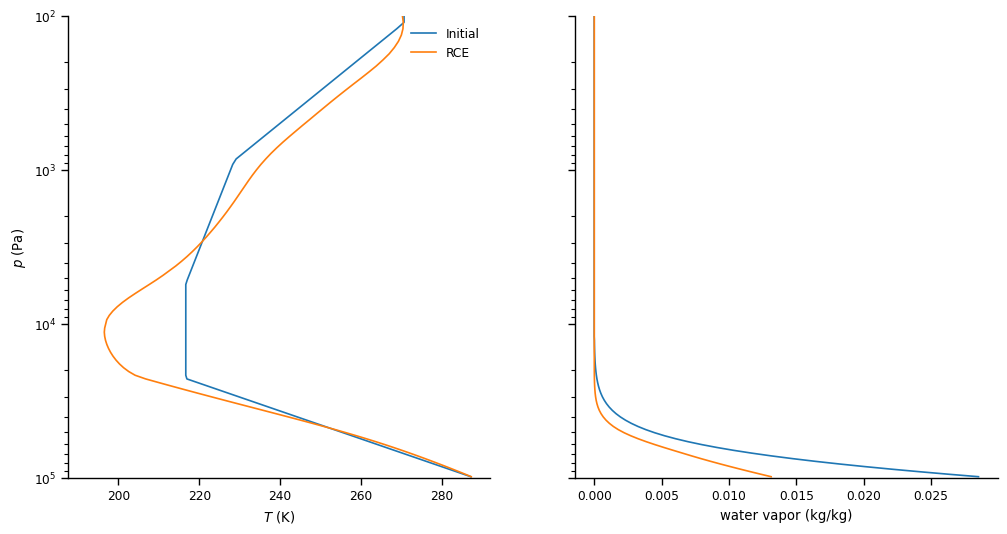

In [74]:
sns.set_context("paper")

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=[12, 6], sharey=True)

ax0.semilogy(initial_conds['T'][0,:], initial_conds['plev'], label = "Initial")
ax0.semilogy(atmosphere   ['T'][0,:], initial_conds['plev'], label = "RCE")
ax0.set_ylim(phlev[0], 100.) 
ax0.set_ylabel("$p$ (Pa)")
ax0.set_xlabel("$T$ (K)")
ax0.legend(frameon = False)

ax1.semilogy(initial_conds['H2O'][0,:], initial_conds['plev'])
ax1.semilogy(atmosphere   ['H2O'][0,:], initial_conds['plev'])
ax1.set_xlabel("water vapor (kg/kg)")

sns.despine() 

**Radiation in RCE**: What does the radiative energy budget look like in the baseline RCE state? We can plot the four components of the radiation budget: up- and down-going radiation for solar (shortwave or sw) and terrestrial (longwave or lw) radiation. The radiation model also tells us the net heating rate. 

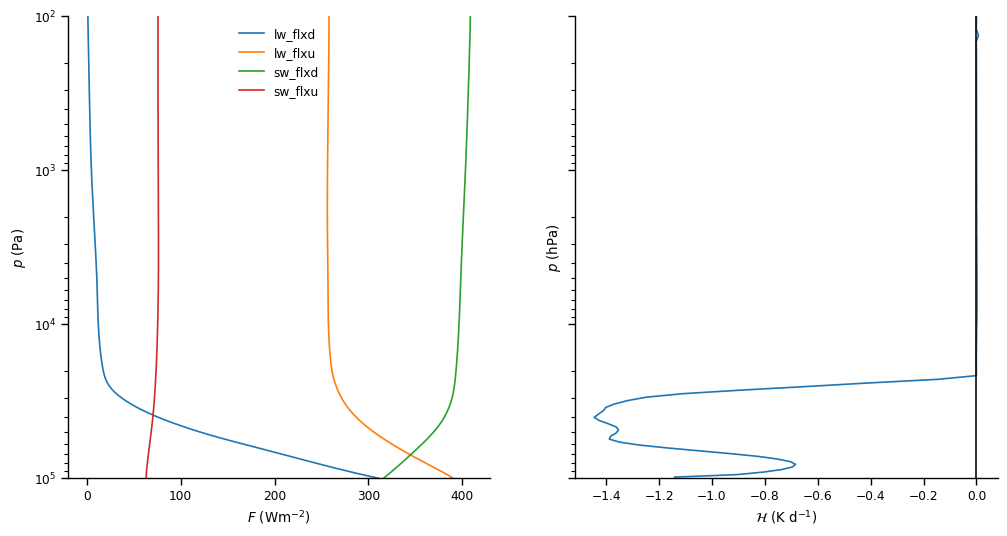

In [75]:
sns.set_context("paper")

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=[12, 6], sharey=True)
# Loop over the four fluxes that make up the 
for v in ['lw_flxd', 'lw_flxu', 'sw_flxd', 'sw_flxu']:
    ax0.semilogy(baseline.radiation[v][0,:], initial_conds['phlev'], label=v)
ax0.set_ylabel("$p$ (Pa)")
ax0.set_xlabel("$F$ (Wm$^{-2}$)")
ax0.legend(frameon = False) 
ax0.set_ylim(phlev[0], 100.) 

ax1.semilogy(baseline.radiation['net_htngrt_clr'][0,:],       initial_conds['plev'])
ax1.set_ylabel("$p$ (hPa)")
ax1.set_xlabel("$\mathcal{H}$ (K d$^{-1}$)")
ax1.axvline(0, color="0.05")
sns.despine() 

**Consider the cooling rate, shown at right** 

At pressures greater than 10$^4$ Pa, or 100 hPa, i.e. in the lowest 90% of mass in the atmopheres, there's a non-zero radiative cooling rate of roughly 1 $K/d$. That's the cooling that's making the atmosphere unstable and leading to convection. 

The upper part of the atmosphere -- the stratosphere and above -- is in radiative equilibrium. We can tell this because there is no net heating or cooling

**What is the total top-of-atmosphere energy imbalance?** 

In [76]:
baseline.radiation["toa"]

array([75.9038868])

Note that this is far from 0, meaning that the tropical region represented by RCE absorbs more sunlight than it emits, on average. On earth this energy is exported from the tropics towards the poles by the atmospheric and oceanic circulations. 

## 1.3 Assignment: Explain the temperature structure and radiative fluxes

a. In a sentence or two, describe the temperature structure of the default atmosphere. 

b. Explain each of the radiative fluxes. In general terms, explain the mechanism of the down-going and up-going amounts of solar (SW) and terrestrial (LW) radiation. 

c. Where is the tropopause? How do you know? 

# 2. How does the atmosphere's temperature structure depend on surface temperature and humidity ?

**Important technical note: Modifying Surface Temperature**: By [default](https://konrad.readthedocs.io/_autosummary/konrad.core.RCE.html) konrad uses a [fixed surface temperature of 288 K](https://konrad.readthedocs.io/_autosummary/konrad.surface.FixedTemperature.html#konrad.surface.FixedTemperature). This can be changed by specifying a different surface temperature when setting up the RCE calculation:  

In [77]:
pert_Ts_286 = konrad.RCE(atmosphere = initial_conds.copy(), 
                         surface=konrad.surface.FixedTemperature(temperature=286))
pert_Ts_286.run()

In [78]:
print("Near-surface temp in baseline:  ", f'{baseline.atmosphere   ["T"][0, 0]:6.4}') 
print("Near-surface temp for T_s = 286:", f'{pert_Ts_286.atmosphere["T"][0, 0]:6.4}') 

Near-surface temp in baseline:    287.3
Near-surface temp for T_s = 286:  285.2


**Important technical note: Modifying Humidity**: By default konrad assumes a constant relative humidity of 80% in the lower part of the atmosphere and a constant specific humdity (water vapor concentration, or absolute humidity) in the stratosphere -- a reasonable simplification to the real world. 

In [79]:
pert_rh_05 = konrad.RCE(atmosphere = initial_conds.copy(), 
                         humidity=konrad.humidity.FixedRH(konrad.humidity.VerticallyUniform(0.5)))
pert_rh_05.run()

In [80]:
print("Near-surface water vapor in baseline: ", f'{baseline.atmosphere   ["H2O"][0, 0]*1000:4.3} g/kg') 
print("Near-surface water vapor for RH = 50%:", f'{pert_rh_05 .atmosphere["H2O"][0, 0]*1000:4.3} g/kg') 

Near-surface water vapor in baseline:  13.1 g/kg
Near-surface water vapor for RH = 50%: 8.21 g/kg


## 2.1. Assignment
a. Plot the vertical structure of temperature for several values of surface temperature and humidity
  - Follow the [example above](#temp_profiles) for plotting and use other code above to make changes to the RCE model
  - Plotting the difference from the surface temperature may be useful. 
    
b. Explain: How does the temperature structure of the (tropical) atmosphere depend on surface temperature and humidity ?

# 3. Instantaneous radiative forcing due to doubling CO$_2$ concentration

In this section, you will calculate the instantaneous radiative forcing due to doubling CO$_2$ from pre-industrial values, explore its dependence on temperature and humidity

**Technical Note 1**
Define a useful function that calculates net downward radiation (down minus up, both shortwave and longwave) 

In [81]:
def compute_N(radiation): 
    """
    Compute net downward radiation from down- and up-going longwave and shortwave radiation 
    """
    return(radiation["lw_flxd"] - radiation["lw_flxu"] + 
           radiation["sw_flxd"] - radiation["sw_flxu"])

**Technical note 2: Running the RCE model in parts to decompose effects**: 
 - Each component of konrad can be run separately, without a full radiative convective equilibrium adjustmnent.
     - This allows us to do process decomposition - breaking down a total change into its component parts. 
 - In this section, we will double CO$_2$ and isolate the radiative effect of this change. 
     - This will give us the instantaneous radiative forcing $F_i$  = the change in net radiation due to the change in CO$_2$ concentration.

In [82]:
# Re-equilibrate the temperature and humidity fields to baseline conditions
rad = konrad.RCE(initial_conds.copy())
rad.run() 
pi_rad = copy.deepcopy(rad.radiation)
# What is the profile of net radiation under pre-industrial conditions? 
N_prof = compute_N(pi_rad)

# Calculate OLR at perturbed atmospheric state.
atmos_2xCO2 = rad.atmosphere.copy() 
# double the CO2 concentration
atmos_2xCO2["CO2"][:] *= 2

# Compute new radiation fields with changing temperature or humidity 
rad.radiation.update_heatingrates(atmos_2xCO2)
twox_rad = copy.deepcopy(rad.radiation)

# The change in the net radiation field as a function of pressure 
inst_rad_forcing = (compute_N(twox_rad) - compute_N(pi_rad))[0,:]

In [83]:
inst_rad_forcing[-1]

2.507237971036261

**Plot the profile of $F_i$   for the baseline to 2xCO2 case, and the radiative fluxes in each**

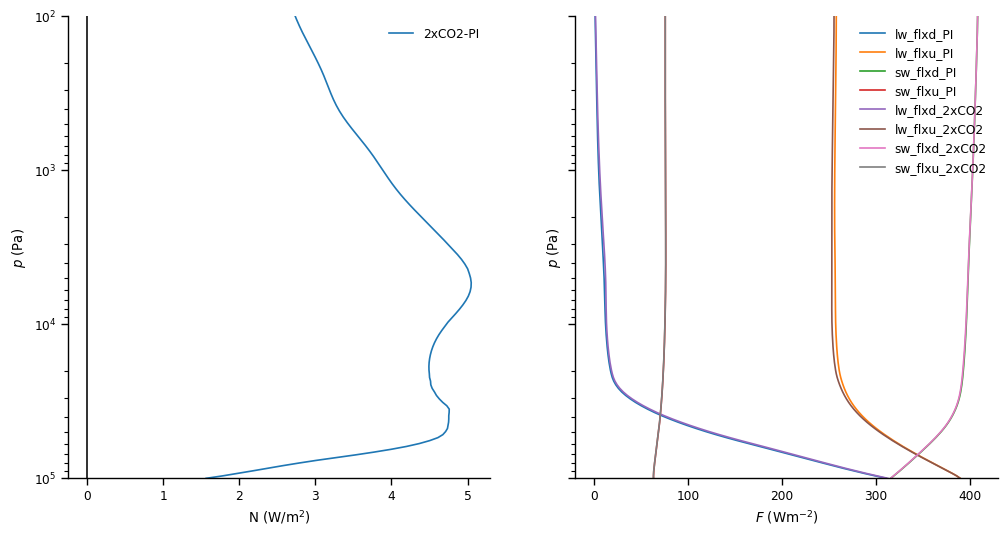

In [84]:
# Plot the instantaneous radiative forcing
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=[12, 6], sharey=True)
ax0.semilogy(inst_rad_forcing,       initial_conds['phlev'],label='2xCO2-PI')
ax0.set_ylabel("$p$ (Pa)")
ax0.set_xlabel("N (W/m$^2$)")
ax0.axvline(0, color="0.05")
ax0.set_ylim(phlev[0], 100.) 
ax0.legend(frameon = False) 

# Loop over the four fluxes that make up the radiation for each run. Note comparatively small changes. 
for v in ['lw_flxd', 'lw_flxu', 'sw_flxd', 'sw_flxu']:
    ax1.semilogy(pi_rad[v][0,:], initial_conds['phlev'], label=v+'_PI')
for v in ['lw_flxd', 'lw_flxu', 'sw_flxd', 'sw_flxu']:
    ax1.semilogy(twox_rad[v][0,:], initial_conds['phlev'], label=v+'_2xCO2')
ax1.set_ylabel("$p$ (Pa)")
ax1.set_xlabel("$F$ (Wm$^{-2}$)")
ax1.legend(frameon = False) 
ax1.set_ylim(phlev[0], 100.) 

sns.despine() 

## 3.1 Assignment 
a. Plot the dependence of $F_i$ at the top of the atmosphere on surface temperature and/or humidity for several values of each variable.

b. Explain the mechanism of these dependencies.

# 4. Effective radiative forcing due to doubling CO$_2$ concentration

In this section, you will calculate the effective radiative forcing due to doubling CO2 concentrations from pre-industrial values and consider the relationship between stratospheric cooling and the radiative adjustment. 

**Important technical note: How to calculate effective radiative forcing**: 
Effective radiative forcing $F$ is the change in N (top of the atmosphere) allowing all aspects of the system _except the surface temperature_ to respond to the forcing agent. Since konrad specifices surface temperature as fixed, $F$ can be computed by changing CO$_2$ concentrations, running the model to equilibrium with the same surface temperature, and comparing the net radiation to the unperturbed state. 

## 4.1 Assignment 
a. Compute the effective radiative forcing for CO$_2$ concentrations doubled from pre-industrial concentrations (e.g. from 280 -> 560 ppmv). 
     - Make a plot comparing the profile of the effective radiative forcing to the profile of instantaneous radiative forcing in question 3.  
     
b. What fraction of $F$, the total response to CO$_2$ doubling, occurs due to the adjustment by stratospheric cooling? 

c. Explain the adjustment of the atmosphere that happens between the instantaneous radiative response and the final equilibrium state. 

# 5. Equilibrium Climate Sensitivity

In this section, you will use konrad to estimate climate sensitivity $S$ from the effective radiative forcing (Question 3) and the climate feedback $S = -\frac{F_{2\times CO_2}}{\lambda}$
<a id='S_from_lambda_F'></a>

**Proceedure to find Climate sensitivity by computing the climate feedback and combining this with estimates of forcing by doubled CO2 concentrations.**
- Establish several baseline simulations at RCE, as in question 1
    - Set up your code so that you can input varying humidity and surface temperature. 
 - Make a small perturbation to the surface temperature, compute the change in top-of-atmosphere net radiation $N$, and the climate feedback $\lambda = \frac{d N}{d T_s}$. 
 - Estimate climate sensitivity $S$ by combining this with the effective radiative forcing (Question 4.1) and the climate feedback $S = -\frac{F_{2\times CO_2}}{\lambda}$
<a id='S_from_lambda_F'></a>

## 5.1 Assignment

a. What is the climate sensitivity for 2xCO2 in radiative-convective equlibrium? 

b. How does climate sensitivity change with humidity and initial surface temperature? 

# 6. Partitioning Climate Feedbacks

## 6.1 Climate forcing and climate feedbacks

As discussed in lecture, radiative forcing is the change in net top-of-atmosphere radiation $N$ caused by a change in state or composition $x_i$. Assuming small perturbations and hence linearity: 

$$
F_i = \frac{d N}{d x_i}
$$

Climate feedbacks are changes in $N$ caused, directly or indirectly, by changes in surface temperature $T_s$

$$
\lambda_i = \frac{\partial N}{\partial x_i} \frac{d  x_i}{d T_s}
$$

In a closed system, such as the global mean or a single column, $N = 0$ in long-term equilibrium (steady state) since otherwise the temperature would change. For a system subject to radiative forcing the net top-of-atmosphere radiation is a balance between the applied forcing and the changing temperature: 
$$
N = F - \lambda \Delta T_s
$$
with 
$$
\lambda = \frac{\partial N}{\partial T_s} + \sum_i  \frac{\partial N}{\partial x_i}\frac{dx_i}{d T_s}  \hspace{0.5in}  (1)
$$

## 6.2 Identifying feedbacks in RCE
<a id='feedbacks-in-rce'></a>

Equation 1 takes the full impact of temperature on N  ($ \lambda = \frac{dN}{dT_s}$) that you considered in section 5 and decomposes it into instantaneous surface temperature feedback $\lambda_{T_s}$ and the sum of additional feedbacks. 

You will find a total of 4 terms for the right-hand size of equation 1:
1. changes in surface temperature (the instantaneous **surface temperature feedback $\lambda_{T_s}$** = $\frac{\partial N}{\partial T_s} $ )
2. changes in atmosphere tempature $\lambda_{T_a}$, which can be further decomposed into 
    1. vertically uniform warming of the atmosphere, or the **atmospheric Planck feedback $\lambda_{Pl}$**
    2. vertically non-uniform warming of the atmosphere, or the **lapse rate feedback $\lambda_{\Gamma}$**
            -  "Lapse rate" describes the rate of change of temperature with pressure $\Gamma(p) = \frac{dT}{dp}$. The connection of lapse rate to feedback arises because, in RCE, the lapse rate is set by the theoretical "moist adiabatic lapse rate" $\Gamma_m(p)$, meaning the variation of temperature with height in a energy-conserving parcel of air in which water is condensing. $\Gamma_m(p)$ depends on temperature and pressure through the dependence of the maximum (saturation) water vapor mixing ratio on temperature.
3. changes in humidity, or the **water vapor feedback $\lambda_{q}$**

## 6.3 Assignment

a. Calculate the 4 terms that decompose the right-hand side of Equation 1, and confirm their sum is equal to $\lambda$. 

b. Change either Ts or RH and interpret the changes in each term and the sum of Equation 1. 

c. Use the code in section 6.3.7 to calculate the Planck, Lapse Rate and Water Vapor feedbacks with constant relative humidity. Interpret why the values are different from what you found in a and b.

### 6.3.1 Technical notes

#### Technical Note 1:
1. Note that $N$ is available directly from a simulation `rce` as `rce.radiation["toa"][-1]`. 
2. For computing feedbacks, i.e. changes in $N$ with respect to an instantaneous change in state, use `rce.radiation.update_heatingrates()` as in Question 3 
3. Remember that instances of konrad (`rce` in the examples above) are persistent, so if surface temperature is changed for one calculation it remains at that value unless explicitly changed again. 

Start with `konrad`'s default distribution of humidity: constant relative humidity RH of 80% in the troposphere and constant above the coldest temperature. 
 - You have seen how to change the tropospheric RH in section 2. 

#### Technical Note 2: Restrict changes to the troposphere 
Because the troposphere is tightly coupled to the surface, water vapor and temperature feedbacks are computed for changes in the troposphere rather than throughout the depth of the atmosphere. To any changes to temperature and humidity to the troposphere, identify the troposphere by identifying a pressure level based on the minimum  𝑇(𝑝) in an equilibrium solution

In [85]:
# Make a mask for tropospheric values
trop = baseline.atmosphere["plev"] > 230.*100.

#### Technical Note 3: temperature and humidity variables
In `konrad`, atmospheric temperature is `base.atmosphere["T"]` while atmosphere (absolute) humidity is `base.atmosphere["H2O"]`.  

However, for the surface temperature, please use `base.surface["temperature"]`

### Restating Equation 1 and its decomposition

$$
\lambda = \frac{\partial N}{\partial T_s} + \sum_i  \frac{\partial N}{\partial x_i}\frac{dx_i}{d T_s}  \hspace{0.5in}  (1)
$$

The right hand side should be decomposed as 
 - $\lambda_{T_s} = \frac{\partial N}{\partial T_s} $  = the instantaneous surface temperature feedback
 
and the sum of
 - $\lambda_{Pl}$ = the atmospheric temperature Planck feedback
 - $\lambda_{\Gamma}$ = the lapse rate feedback
 - $\lambda_{q}$ = the water vapor feedback

To find $\lambda_{Pl}$ and $\lambda_{\Gamma}$, find the atmosphere temperature $\lambda_{T_a}$ and separate it into its two parts:
 - vertically uniform warming of the atmosphere (atmospheric Planck feedback $\lambda_{Pl})$
 - vertically non-uniform warming of the atmosphere (lapse rate feedback $\lambda_{\Gamma})$

## 6.3.2 Find the instantaneous response to a change in surface temperature (the surface temperature feedback $\lambda_{T_s}$)

By not re-running to equilibrium, your calculation keeps the absolute humidity unchanged (in contrast to RCE re-adjusting to the set relative humidity)

## 6.3.3 Planck and Lapse rate feedbacks via atmospheric warming and its decomposition
If the atmosphere warms its emission to space will increase - a negative feedback. This atmospheric temperature feedback $\lambda_{T_a}$ can be further decomposed into

-  an atmospheric Planck feedback $\lambda_{Pl}$ associated with vertically uniform warming of the same magnitude as the surface temperature change
- lapse-rate feedback $\lambda_{\Gamma}$ associated with vertically non-uniform warming. 


### 6.3.3.1 Compute $\lambda_{T_a}$ by replacing the temperature profile in an equilibrium solution at $T_s$ by the temperature profile from a solution at $T_s +1$ and recomputing fluxes.


By not re-running to equilibrium, your calculation keeps the absolute humidity unchanged (in contrast to RCE re-adjusting to the set relative humidity).

### 6.3.3.2 The Planck feedback $\lambda_{Pl}$ can be obtained by warming the troposphere uniformly by 1K and recomputing fluxes. 

By not re-running to equilibrium, your calculation keeps the absolute humidity unchanged (in contrast to RCE re-adjusting to the set relative humidity).

### 6.3.3.3 Find the lapse rate feedback by difference: $\lambda_{\Gamma} = \lambda_{T_a} - \lambda_{Pl}$. 

## 6.3.4 The water vapor feedback can be computed by replacing the water vapor concentration profile (`base.atmosphere["H2O"]`) in an equilibrium solution at $T_s$ by the water vapor concentration profile from the solution at $T_s +1$ and recomputing fluxes.

By not re-running to equilibrium, your calculation keeps the absolute humidity unchanged (in contrast to RCE re-adjusting to the set relative humidity).

## 6.3.5 Interpret your results in the context of equation 1

## 6.3.6 Change RH or Ts for 6.3.2 to 6.3.4, interpret results

## 6.3.7 Use the code provided below to find planck, lapse rate and water vapor feedbacks for constant relative humidity. Interpret these results.

As discussed by [Isaac Held and Karen Shell (2012)](https://10.1175/JCLI-D-11-00721.1), the magnitude of the lapse rate and water feedbacks depend on which state variable is used to represent water vapor, which is equivalent to choosing a reference response. If we characterize water vapor by its _absolute concentration_, feedbacks are measured against a world in which absolute concentration doesn't change with temperature, meaning that relative humidity decreases with warming. If we characterize water vapor by its _relative concentration_ or _relative humidity_ (relative being measured with respect to temperature-dependent saturation), then the feedbacks are measured in a world in which warmer is also wetter. 

In this RCE model, in which relative humidity is constant by construction, using an absolute humidity framework leads to large lapse rate and water vapor feedbacks of opposite sign, while using a relative humidity framework yields much smaller feedbacks. 

In [86]:
Ts = 288
RH = 0.8

In [87]:
base = konrad.RCE(atmosphere = initial_conds.copy(), 
                surface=konrad.surface.FixedTemperature(temperature=Ts),
                humidity=konrad.humidity.FixedRH(konrad.humidity.VerticallyUniform(RH)))
base.run()
#---- 
# Surface T + 1
pert = konrad.RCE(atmosphere = base.atmosphere.copy(), 
                surface=konrad.surface.FixedTemperature(temperature=Ts+1),
                humidity=konrad.humidity.FixedRH(konrad.humidity.VerticallyUniform(RH)))
pert.run()

In [88]:
# Atmospheric T feedback
rad = copy.deepcopy(base)
# Use the perturbed atmosphere in which atmosphere has warmed 1 degree
rad.atmosphere["H2O"][0,:][trop] = pert.atmosphere["H2O"][0,:][trop]
rad.atmosphere["T"]  [0,:][trop] = pert.atmosphere["T"]  [0,:][trop]
rad.radiation.update_heatingrates(rad.atmosphere, rad.surface)
lambda_T_a_RH = rad.radiation["toa"][-1] - base.radiation["toa"][-1]
print("Const. RH, atmospheric T feedback:", np.round(lambda_T_a_RH, 2), " W/m2-K")

Const. RH, atmospheric T feedback: -0.39  W/m2-K


In [89]:
# Planck Feedback
rad = copy.deepcopy(base)
# warm atmosphere uniformly by 1K
rad.atmosphere["T"]  [0,:][trop] = base.atmosphere["T"]  [0,:][trop]+1
# update the humidity to constant RH
rad.atmosphere["H2O"][0,:][trop] = konrad.physics.relative_humidity2vmr(RH, base.atmosphere["plev"][trop],rad.atmosphere["T"]  [0,:][trop])
# recompute fluxes 
rad.radiation.update_heatingrates(rad.atmosphere, rad.surface)
# plank feedback
lambda_planck_RH = rad.radiation["toa"][-1] - base.radiation["toa"][-1]
print("Const. RH, Planck feedback:", np.round(lambda_planck_RH, 2), " W/m2-K")

Const. RH, Planck feedback: -0.34  W/m2-K


In [90]:
# Find lapse rate feedback here

In [91]:
# Water Vapor Feedback 
rad_wv = copy.deepcopy(base)
# use wv profile from solution at Ts+1
rad_wv.atmosphere["H2O"][0,:][trop] = pert.atmosphere["H2O"][0,:][trop] 
# update the humidity to constant RH
rad_wv.atmosphere["H2O"][0,:][trop] = konrad.physics.relative_humidity2vmr(RH, base.atmosphere["plev"][trop],rad_wv.atmosphere["T"]  [0,:][trop])
# recompute fluxes
rad_wv.radiation.update_heatingrates(rad_wv.atmosphere, rad_wv.surface)
# wv feedback
lambda_wv_RH = rad_wv.radiation["toa"][-1] - base.radiation["toa"][-1]
print("Const. RH,  water vapor:", np.round(lambda_wv_RH , 2), " W/m2-K")

Const. RH,  water vapor: -0.0  W/m2-K
